This is an example solution to the Bio Data Scientist technical screen, using the data in `simulated_counts.txt`.  This solution is in Python, and generally the solution should be similar for R.  There are several key things we are looking for.  

- How much are they inspecting the data.
- How much are they plotting the data.
- Are they aware of gotchas.

In [1]:
import pandas as pd

x = pd.read_csv("simulated_counts.txt", sep = "\t")
print(x.shape)
x.head()

(42000, 6)


,gene,spacer,control_1,control_2,condition_1,condition_2
0,1,TCAAGGTGTGTTAAAGTTTT,260,86,18,3
1,1,GTCCCTTGTAATTACGGATT,118,95,8,7
2,1,TGTAAACCTAGATTGACCTT,167,44,7,3
3,1,CCGAAGTGTGTCCTGAATCT,88,86,28,23
4,1,TGATCCACGCTTTTATCTTA,96,92,6,6


In [2]:
# how many genes are there?
x['gene'].nunique()

2001

In [3]:
# how many of each gene?
x['gene'].value_counts().value_counts()

20      2000
2000       1
Name: gene, dtype: int64

In [4]:
x['gene'].value_counts()

random    2000
743         20
251         20
879         20
1851        20
          ... 
1990        20
333         20
587         20
1724        20
238         20
Name: gene, Length: 2001, dtype: int64

In [5]:
# create variable for negative control guides
x['random'] = (x['gene'] == 'random')
sum(x['random'])

2000

In [6]:
import numpy as np
x['lfc_1'] = np.log(x['condition_1'] + 1) - np.log(x['control_1'] + 1)
x['lfc_2'] = np.log(x['condition_2'] + 1) - np.log(x['control_2'] + 1)
x.head()

,gene,spacer,control_1,control_2,condition_1,condition_2,random,lfc_1,lfc_2
0,1,TCAAGGTGTGTTAAAGTTTT,260,86,18,3,False,-2.620081,-3.079614
1,1,GTCCCTTGTAATTACGGATT,118,95,8,7,False,-2.581899,-2.484907
2,1,TGTAAACCTAGATTGACCTT,167,44,7,3,False,-3.044522,-2.420368
3,1,CCGAAGTGTGTCCTGAATCT,88,86,28,23,False,-1.121341,-1.287854
4,1,TGATCCACGCTTTTATCTTA,96,92,6,6,False,-2.628801,-2.586689


<AxesSubplot:xlabel='lfc_1', ylabel='lfc_2'>

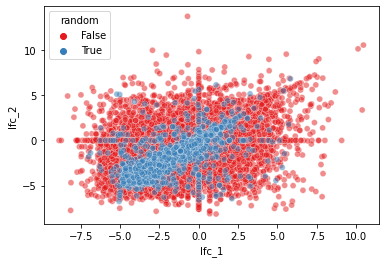

In [7]:
# how consistent are the replicates?
import seaborn
seaborn.scatterplot(data = x, x = 'lfc_1', y = 'lfc_2', hue = 'random', alpha = 0.5, palette = 'Set1')

In [8]:
x[['lfc_1', 'lfc_2']].corr()

,lfc_1,lfc_2
lfc_1,1.000000,0.664937
lfc_2,0.664937,1.000000


In [9]:
col = x.loc[: , "lfc_1":"lfc_2"]
x['avg_lfc'] = col.mean(axis=1)
x.head()

,gene,spacer,control_1,control_2,condition_1,condition_2,random,lfc_1,lfc_2,avg_lfc
0,1,TCAAGGTGTGTTAAAGTTTT,260,86,18,3,False,-2.620081,-3.079614,-2.849848
1,1,GTCCCTTGTAATTACGGATT,118,95,8,7,False,-2.581899,-2.484907,-2.533403
2,1,TGTAAACCTAGATTGACCTT,167,44,7,3,False,-3.044522,-2.420368,-2.732445
3,1,CCGAAGTGTGTCCTGAATCT,88,86,28,23,False,-1.121341,-1.287854,-1.204597
4,1,TGATCCACGCTTTTATCTTA,96,92,6,6,False,-2.628801,-2.586689,-2.607745


<AxesSubplot:xlabel='avg_lfc', ylabel='Density'>

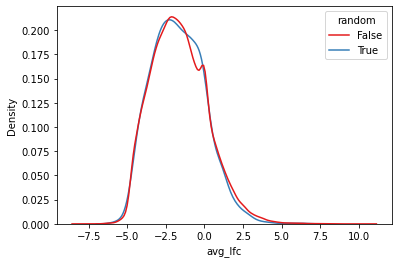

In [10]:
# look at the distribution of avg log fc
seaborn.kdeplot(data = x, x = 'avg_lfc', hue = 'random', palette = 'Set1', common_norm = False)

In [11]:
x['avg_lfc'].mean()

-1.6198415259162453

In [12]:
x['avg_lfc'] = x['avg_lfc'] - x['avg_lfc'].mean()

In [13]:
x['avg_lfc'].std()

1.7854607566810077

In [14]:
neg_ctrl_sd = x[x['random'] == True]['avg_lfc'].std()
neg_ctrl_sd

1.682671818634517

In [15]:
import scipy.stats as stats

x['norm_p_val'] = x['avg_lfc'].map(lambda y: 1.0 - stats.norm.cdf(y, loc = 0, scale = neg_ctrl_sd))
x.head()

,gene,spacer,control_1,control_2,condition_1,condition_2,random,lfc_1,lfc_2,avg_lfc,norm_p_val
0,1,TCAAGGTGTGTTAAAGTTTT,260,86,18,3,False,-2.620081,-3.079614,-1.230006,0.767606
1,1,GTCCCTTGTAATTACGGATT,118,95,8,7,False,-2.581899,-2.484907,-0.913561,0.706409
2,1,TGTAAACCTAGATTGACCTT,167,44,7,3,False,-3.044522,-2.420368,-1.112604,0.745762
3,1,CCGAAGTGTGTCCTGAATCT,88,86,28,23,False,-1.121341,-1.287854,0.415244,0.402541
4,1,TGATCCACGCTTTTATCTTA,96,92,6,6,False,-2.628801,-2.586689,-0.987904,0.721433


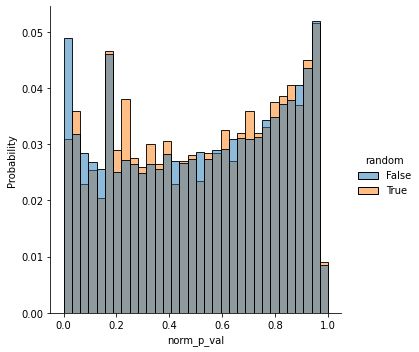

In [16]:
seaborn.displot(data = x, x = 'norm_p_val', hue = 'random', kde = False,
                stat = 'probability', common_norm = False)

The above looks fairly good.  There's a spike near zero which indicates signal, and the rest looks about uniform.  Checking the distribution of the p-values is critical, however they generate the p-values.  The check that there's a spike near zero to indicate signal is important for a post-hoc validation.

Now the problem is how to combine p-values.  The most common way is Fisher's method.  If they use this, the major question is what are the drawbacks and benefits of using Fisher's method.  If they've done their research then they would know my feelings about Fisher's method here (see https://timydaley.github.io/FisherVsStouffer.html).

In [17]:
from scipy.stats import combine_pvalues
def fishers_pval(p):
    _, f = combine_pvalues(p, method = 'fisher')
    return f

by_gene = x.groupby('gene', as_index = False)['avg_lfc'].mean()
by_gene.sort_values(by = 'gene', inplace = True)
by_gene.head()

,gene,avg_lfc
0,1,-0.209156
1,10,-0.280732
2,100,-0.449904
3,1000,-0.156761
4,1001,-0.218284


In [18]:
by_gene['fisher_pval'] = [fishers_pval(x[x['gene'] == g]['norm_p_val']) for g in by_gene['gene'].tolist()]
by_gene.head()

,gene,avg_lfc,fisher_pval
0,1,-0.209156,0.784617
1,10,-0.280732,0.853722
2,100,-0.449904,0.776185
3,1000,-0.156761,0.326385
4,1001,-0.218284,0.603739


/Users/tim.daley/git/crispy_code/py39/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fisher_pval'>

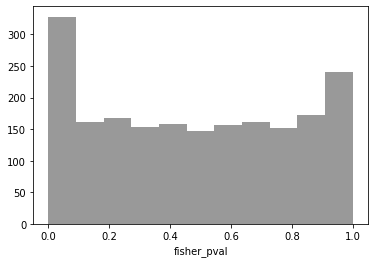

In [19]:
seaborn.distplot(by_gene['fisher_pval'], kde = False, color = 'black')

This looks good.  Let's look at the top hits.

In [20]:
by_gene.sort_values(by = 'fisher_pval', ascending = True).head()

,gene,avg_lfc,fisher_pval
1257,33,2.132870,2.250800e-14
1942,947,2.335407,4.442688e-12
1536,581,1.992590,2.817394e-11
1897,906,2.276410,4.465489e-11
791,1710,1.924818,5.145688e-11


/Users/tim.daley/git/crispy_code/py39/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_lfc', ylabel='Density'>

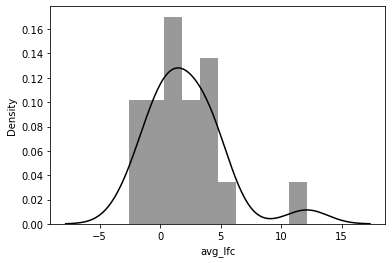

In [25]:
# looks like a hit
seaborn.distplot(x.loc[x['gene'] == str(33), 'avg_lfc'], color = 'black', bins = 10)

/Users/tim.daley/git/crispy_code/py39/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_lfc', ylabel='Density'>

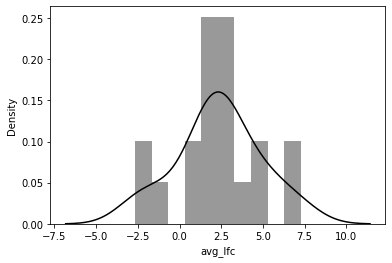

In [26]:
# does not look like a hit
seaborn.distplot(x.loc[x['gene'] == str(947), 'avg_lfc'], color = 'black', bins = 10)

/Users/tim.daley/git/crispy_code/py39/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_lfc', ylabel='Density'>

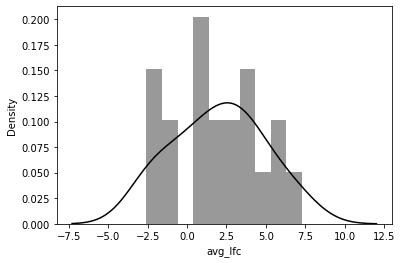

In [27]:
# is this a hit?
seaborn.distplot(x.loc[x['gene'] == str(581), 'avg_lfc'], color = 'black', bins = 10)

In [28]:
by_gene.sort_values(by = 'avg_lfc', ascending = False).head()

,gene,avg_lfc,fisher_pval
1942,947,2.335407,4.442688e-12
1897,906,2.276410,4.465489e-11
385,1345,2.240317,2.602018e-10
1257,33,2.132870,2.250800e-14
1536,581,1.992590,2.817394e-11
